# RNN - Insurance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving weekly_data_clean.xlsx to weekly_data_clean (1).xlsx


In [3]:
import io
data = pd.read_excel(io.BytesIO(uploaded['weekly_data_clean.xlsx']))

In [4]:
data = data.drop(columns=['Unnamed: 0', 'date_issue'])

In [5]:
data

,total_amount_claims
0,16683
1,201774
2,263661
3,799703
4,900305
...,...
127,1949930
128,1725225
129,2232202
130,2666662


In [6]:
print("min: ",data['total_amount_claims'].min())
print("max: ",data['total_amount_claims'].max())

min:  16683
max:  2666662


In [7]:
data.shape

(132, 1)

In [8]:
min_ = data['total_amount_claims'].min()
max_ = data['total_amount_claims'].max()

data['total_amount_claims'] = [((x - min_) / (max_ - min_)) for x in data['total_amount_claims']]

In [9]:
data

,total_amount_claims
0,0.000000
1,0.069846
2,0.093200
3,0.295482
4,0.333445
...,...
127,0.729533
128,0.644738
129,0.836052
130,1.000000


### Split data

In [10]:
len_ = int(0.8*data.shape[0])

data_train = data[:len_]
data_test = data[len_:]

In [11]:
print(data_train.shape)
print(data_test.shape)

(105, 1)
(27, 1)


### Sequences

In [12]:
def subsample_sequence(data, length):
    
    last_possible = data.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    data_sample = data[random_start: random_start+length]
    
    return data_sample

In [13]:
data_subsample = subsample_sequence(data, 10)
data_subsample

,total_amount_claims
15,0.102129
16,0.171793
17,0.049786
18,0.083963
19,0.052248
20,0.187774
21,0.120908
22,0.164886
23,0.160679
24,0.219325


In [14]:
def fillna(X, data_mean):
    # Replace with NaN of the other hours. 
    na = X.mean()
    
    # If the other hours are also nans, then replace with mean value of the dataframe
    na.fillna(data_mean)
    return na

def split_subsample_sequence(data, length, data_mean=None):
    # Little trick to improve the time
    if data_mean is None:
        data_mean = data.mean()
              
    data_subsample = subsample_sequence(data, length)
    y_sample = data_subsample.iloc[data_subsample.shape[0]-1]['total_amount_claims']
    
    if y_sample != y_sample: # A value is not equal to itself only for NaN. So it will be True if y_sample is nan
        X_sample, y_sample = split_subsample_sequence(data, length, data_mean)
        return np.array(X_sample), np.array(y_sample)
    
    X_sample = data_subsample[0:data_subsample.shape[0]-1]
    X_sample = X_sample.fillna(fillna(X_sample, data_mean))
    X_sample = X_sample.values
    
    return np.array(X_sample), np.array(y_sample)

In [15]:
def get_X_y(data, number_of_sequences, length):
    X, y = [], []

    for i in range(number_of_sequences):
        xi, yi = split_subsample_sequence(data, length)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)
        
    return X, y

In [16]:
X_train, y_train = get_X_y(data_train, 80, 10)
X_test, y_test = get_X_y(data_test, 20, 10)

In [ ]:
# !pip install tensorflow

In [17]:
print(f'X train size:{X_train.shape}')
print(f'X test size:{X_test.shape}')
print(f'y train size:{y_train.shape}')
print(f'y test size:{y_test.shape}')

X train size:(80, 9, 1)
X test size:(20, 9, 1)
y train size:(80,)
y test size:(20,)


In [45]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()

model.add(layers.LSTM(20, activation='tanh', return_sequences=True))
model.add(layers.LSTM(20, activation='tanh'))

model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))

model.add(layers.Dense(1, activation='linear'))

In [46]:
model.compile(loss='mse', 
              optimizer='rmsprop', 
              metrics=['mse', 'mae', 'mape'])

In [48]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
            validation_split=0.2,
            epochs=200, 
            batch_size=32,
            verbose=1,
            callbacks=[es])

Epoch 1/200
2/2 [==============================] - 4s 1s/step - loss: 0.0477 - mse: 0.0477 - mae: 0.1965 - mape: 96.6054 - val_loss: 0.0571 - val_mse: 0.0571 - val_mae: 0.1899 - val_mape: 82.2657
Epoch 2/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0372 - mse: 0.0372 - mae: 0.1681 - mape: 79.1313 - val_loss: 0.0478 - val_mse: 0.0478 - val_mae: 0.1646 - val_mape: 66.3264
Epoch 3/200
2/2 [==============================] - 0s 34ms/step - loss: 0.0286 - mse: 0.0286 - mae: 0.1425 - mape: 66.7180 - val_loss: 0.0398 - val_mse: 0.0398 - val_mae: 0.1423 - val_mape: 55.5668
Epoch 4/200
2/2 [==============================] - 0s 34ms/step - loss: 0.0258 - mse: 0.0258 - mae: 0.1228 - mape: 53.5133 - val_loss: 0.0318 - val_mse: 0.0318 - val_mae: 0.1175 - val_mape: 46.1296
Epoch 5/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.0937 - mape: 46.4739 - val_loss: 0.0254 - val_mse: 0.0254 - val_mae: 0.0963 - val_mape: 40.3015
Epoch 6/200


In [49]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 9, 20)             1760      
_________________________________________________________________
lstm_4 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [52]:
model_eval = model.evaluate(X_test, y_test, verbose=0)
print(f'Model Mean Absolute Error {model_eval[1]:.4f}')
print(f'Model Mean Absolute Porcentual Error {model_eval[2]:.4f}')

Model Mean Absolute Error 0.0188
Model Mean Absolute Porcentual Error 0.1053


#### Prediction

In [53]:
predict = model.predict(X_test)

In [60]:
import tensorflow as tf
mape = tf.keras.metrics.mape(y_test, predict)
mape_metric = model.compile(metrics=mape)
mape

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([16.104607, 18.423315, 18.423315, 17.355072, 27.003586, 17.355072,
       16.001001, 18.423315, 16.104607, 15.37399 , 15.650686, 19.638023,
       16.001001, 15.976557, 16.508095, 19.638023, 15.650686, 22.697037,
       22.8645  , 18.423315], dtype=float32)>

In [59]:
loss = 100 * np.mean(abs((y_test - predict) / y_test), axis=-1)
loss

array([16.10460552, 18.42331662, 18.42331662, 17.35507237, 27.003585  ,
       17.35507237, 16.00099928, 18.42331662, 16.10460552, 15.37399042,
       15.65068727, 19.63802245, 16.00099928, 15.97655722, 16.50809571,
       19.63802245, 15.65068727, 22.6970361 , 22.86449907, 18.42331662])

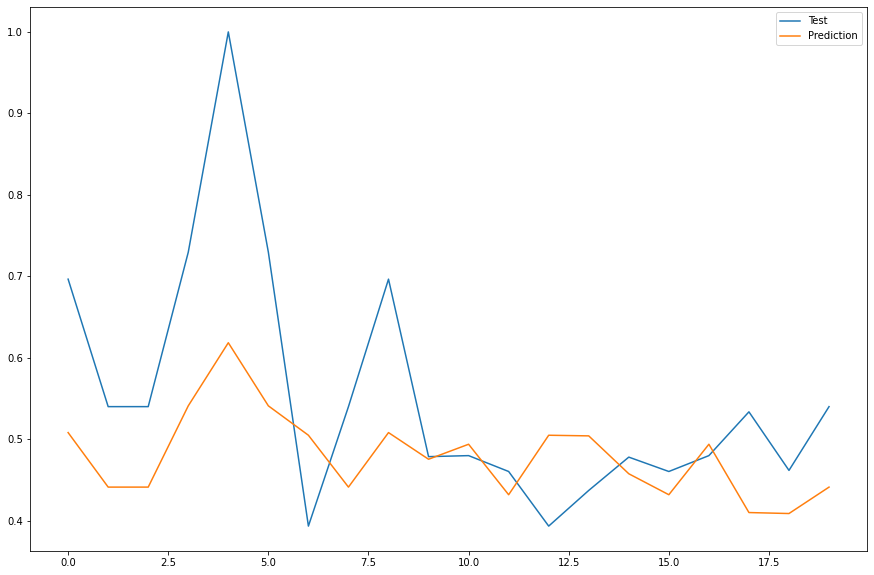

In [55]:
plt.figure(figsize=(15,10))
plt.plot(y_test,label = 'Test')
plt.plot(predict, label = 'Prediction')
plt.legend(loc='best')
plt.show()